# Virus on a Network Surrogate Modelling

This tutorial will cover the development of surrogate models on Virus on a Network, and the potential applications of such models. A surrogate model is an approximate model used to emulate a more expensive or complex simulation.   It is trained on input-output data from the original model to predict outcomes quickly. Surrogate models are commonly used in optimisation, uncertainty quantification, and sensitivity analysis to reduce computational costs.

[A very informative e-book on surrogate modelling can be found here](https://bookdown.org/rbg/surrogates/).

In surrogate modeling, **loss emulation** and **output emulation** are two distinct approaches. Output emulation focuses on directly approximating the simulator’s outputs given inputs, essentially creating a surrogate that mimics the true model. Loss emulation, on the other hand, approximates a scalar **loss function** (e.g., error, likelihood, or cost) derived from the simulator’s outputs, rather than the outputs themselves. This can be advantageous when the final decision depends only on the loss, allowing the surrogate to concentrate on regions of the input space that matter most for optimisation, rather than modeling the entire output surface.

## Running Virus on a Network

It is possible to run Virus on a Network from a [Solara dashboard](https://solara.dev/) to get an idea of what our agent-based simulation model looks like.

In [ ]:
! solara run voan_app.py --host 0.0.0.0 --port 8765

# Imports

We will first import all required dependencies and specify our constants.

In [2]:
from voan import VirusOnNetwork
import pandas as pd

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.sensitivity import (
	SensitivityAnalysisMethod,
	SensitivityAnalysisMethodModel,
)
from calisim.surrogate import (
	SurrogateModelMethod,
	SurrogateModelMethodModel,
)
from calisim.uncertainty import (
	UncertaintyAnalysisMethod,
	UncertaintyAnalysisMethodModel,
)
import numpy as np

N_DAYS = 30
NUM_NODES = 250
AVG_NODE_DEGREE = 3
INITIAL_OUTBREAK_SIZE = 20
VIRUS_CHECK_FREQUENCY = 0.4

reference_virus_spread_chance=0.1
reference_recovery_chance=0.3
reference_gain_resistance_chance=0.5

In [3]:
model = VirusOnNetwork(
    num_nodes = NUM_NODES,
    avg_node_degree = AVG_NODE_DEGREE,
    initial_outbreak_size = INITIAL_OUTBREAK_SIZE,
    virus_spread_chance = reference_virus_spread_chance,
    virus_check_frequency = VIRUS_CHECK_FREQUENCY,
    recovery_chance = reference_recovery_chance,
    gain_resistance_chance = reference_gain_resistance_chance,
)

for _ in range(N_DAYS):
    model.step()
    
reference_state_df = model.datacollector.get_model_vars_dataframe()
reference_state_df

,Infected,Susceptible,Resistant,R over S,Effect R,Contact R-Naught,Proxy Contact R-Naught
0,20,230,0,0.000000,0.000000,0.000000,0.000000
1,25,225,0,0.000000,1.500000,1.533333,0.766667
2,28,221,1,0.004525,1.000000,1.040724,0.858019
3,33,216,1,0.004630,1.000000,1.064815,0.909718
4,32,215,3,0.013953,1.000000,1.069767,0.941728
5,38,205,7,0.034146,1.090909,1.223947,0.988764
6,41,200,9,0.045000,1.000000,1.150000,1.011798
7,45,193,12,0.062176,1.000000,1.191710,1.034287
8,46,188,16,0.085106,1.000000,1.223404,1.055300
9,49,179,22,0.122905,1.090909,1.401727,1.089943


# Calibration procedure

## Surrogate Modelling

We will next train a loss emulation surrogate model for a sensitivity analysis. Again, we will focus on the analysis of the estimate of $R_0$. 

We will next run the reliability analysis. For this exercise, there are three parameters of interest within Virus on a Network: 

- **virus_spread_chance**: The probability of infection.
- **recovery_chance**: The probability of recovery.
- **gain_resistance_chance**:  The probability of gaining disease resistance.

We will first specify our parameter distributions:

In [4]:
parameter_spec = ParameterSpecification(
    parameters=[
        DistributionModel(
            name="virus_spread_chance",
            distribution_name="uniform",
            distribution_args=[0.08, 0.2],
			data_type=ParameterDataType.CONTINUOUS,
        ),
        DistributionModel(
            name="recovery_chance",
            distribution_name="uniform",
            distribution_args=[0.2, 0.4],
			data_type=ParameterDataType.CONTINUOUS,
        ),
        DistributionModel(
            name="gain_resistance_chance",
            distribution_name="uniform",
            distribution_args=[0.4, 0.6],
			data_type=ParameterDataType.CONTINUOUS,
        )
    ]
)

We will next define our sensitivity analysis function. We will run the Virus on a Network simulation for 30 days with 250 agents, and subsequently extract the end-of-simulation median consensus estimate of $R_0$ produced by the model.

In [5]:
def sensitivity_func(
    parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    model = VirusOnNetwork(
        num_nodes = NUM_NODES,
        avg_node_degree = AVG_NODE_DEGREE,
        initial_outbreak_size = INITIAL_OUTBREAK_SIZE,
        virus_spread_chance = parameters["virus_spread_chance"],
        virus_check_frequency = VIRUS_CHECK_FREQUENCY,
        recovery_chance = parameters["recovery_chance"],
        gain_resistance_chance = parameters["gain_resistance_chance"],
    )
    
    for _ in range(N_DAYS):
        model.step()
    
    state_df = model.datacollector.get_model_vars_dataframe()
    end_state = state_df.tail(1)
    r_0 = np.median(end_state[["Contact R-Naught", "Proxy Contact R-Naught"]].values)
    
    return r_0

[We'll fit a polynomial chaos expansion (PCE) surrogate using the OpenTurns package](https://openturns.github.io/openturns/latest/auto_reliability_sensitivity/sensitivity_analysis/plot_functional_chaos_sensitivity.html#sphx-glr-auto-reliability-sensitivity-sensitivity-analysis-plot-functional-chaos-sensitivity-py).

Recall that for PCE, we approximate a model output $Y$ as:

$$
Y \approx \hat{Y} = \sum_{i} c_{\mathbf{\alpha}_i} \Psi_{\mathbf{\alpha}_i}(\mathbf{X})
$$

- $\Psi_{\mathbf{\alpha}_i}(\mathbf{X})$ are orthogonal polynomials of the inputs.  
- $c_{\mathbf{\alpha}_i}$ are expansion coefficients.  
- $i$ indexes the polynomial terms.

One can derive the Sobol sensitivity indices analytically from the coefficients of the PCE model; no Monte Carlo sampling is required. [More information can be found here](https://www.sciencedirect.com/science/article/abs/pii/S0951832007001329). Also note that the classical Sobol analysis assumes that your function of interwst is deterministic, and is therefore not appropriate for agent-based models. Conversely, a probablistic surrogate (such as a PCE or Gaussian proccess surrogate) is able to model the noise distribution of a noisy simulator, given that enough replicate simulations have been executed, and is therefore more appropriate for a sensitivity analysis of agent-based models. 

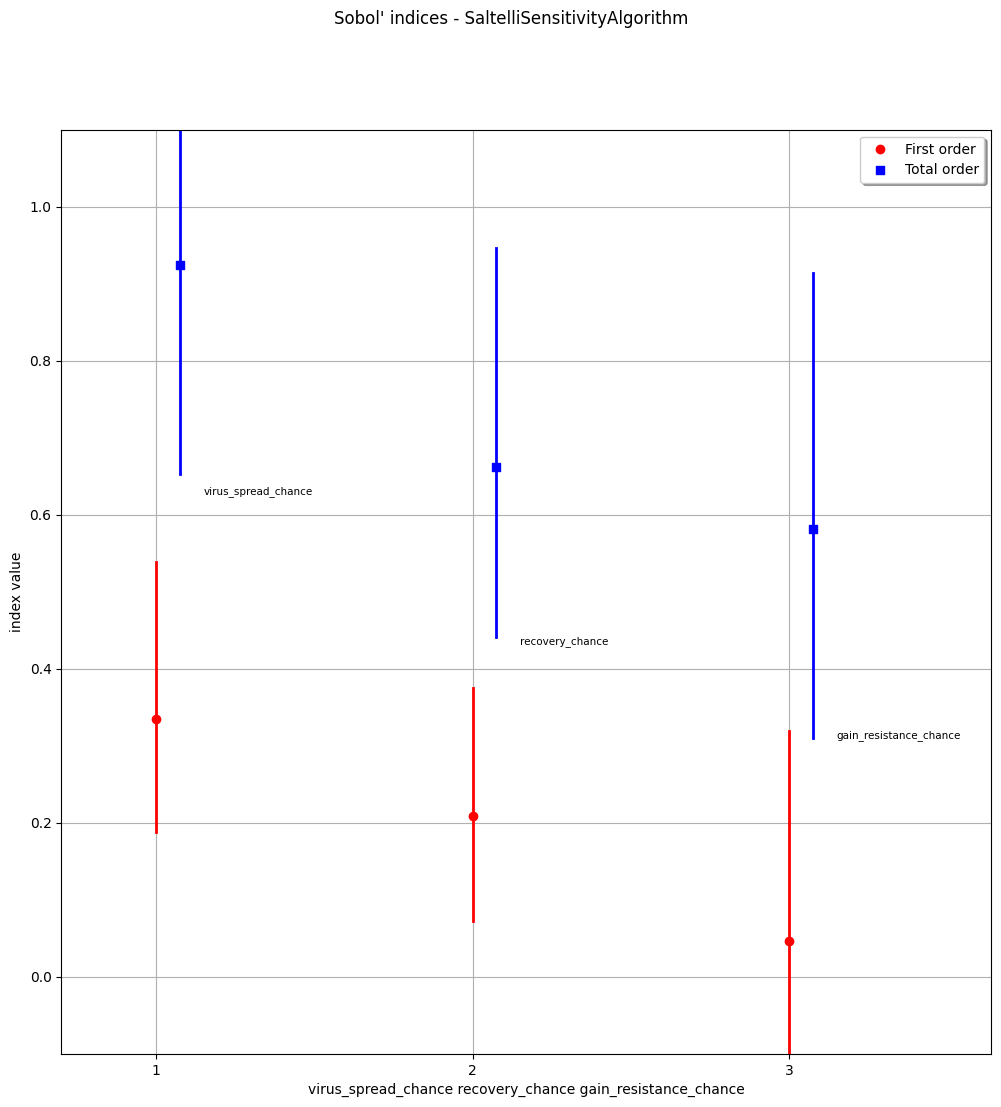

In [14]:
specification = SensitivityAnalysisMethodModel(
	experiment_name="openturns_sensitivity_analysis",
	parameter_spec=parameter_spec,
	method="saltelli",
	n_samples=128,
    order=2,
    n_jobs=1,
    output_labels=["Median consensus R-Naught"],
	verbose=True,
	batched=False,

)

calibrator = SensitivityAnalysisMethod(
	calibration_func=sensitivity_func, specification=specification, engine="openturns"
)

calibrator.specify().execute().analyze()

In [13]:
pd.DataFrame({
    "parameter_names": ["virus_spread_chance", "recovery_chance", "gain_resistance_chance"],
    "first_order": list(calibrator.implementation.first_order),
    "total_order": list(calibrator.implementation.total_order)
})

,parameter_names,first_order,total_order
0,virus_spread_chance,0.207347,0.754579
1,recovery_chance,0.129293,0.757078
2,gain_resistance_chance,-0.102036,0.688382


According to the sensitivity analysis results, the direct influence of **virus_spread_chance** and **recovery_chance**  on the variation of $R_0$ is quite small, although it has a strong impact on $R_0$ when accounting for two-way interactions.

We'll next make use of an alternative method to performing a surrogate-based sensitivity analysis via an approach that is more commonly applied within machine learning. We will use [SHapley Additive exPlanations (SHAP)](https://christophm.github.io/interpretable-ml-book/shapley.html) for both a local and global sensitivity analysis.

SHAP works by treating each feature like a player in a game trying to earn the model's prediction. For every possible subset of features, it asks: "If I add this feature, how much does it change the prediction?" Then it averages that contribution over all possible feature combinations thereby giving each feature its fair share of the prediction.

[We'll next fit a Gaussian process surrogate model using scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor). There are several advantages to using a Gaussian process as the surrogate: 

- **Quantifies uncertainty:** Each prediction provides both a mean and variance.  
- **Performs well with small datasets:** GPs generalise smoothly from limited samples.  
- **Non-parametric flexibility:** Can model highly nonlinear relationships.  
- **Supports active learning:** Uncertainty guides efficient sample selection (e.g., Bayesian optimisation).  
- **Interpretability:** Kernel functions encode assumptions like smoothness or periodicity.  

We first specify our surrogate modelling function as per the sensitivity analysis.

In [15]:
def surrogate_modelling_func(
    parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    model = VirusOnNetwork(
        num_nodes = NUM_NODES,
        avg_node_degree = AVG_NODE_DEGREE,
        initial_outbreak_size = INITIAL_OUTBREAK_SIZE,
        virus_spread_chance = parameters["virus_spread_chance"],
        virus_check_frequency = VIRUS_CHECK_FREQUENCY,
        recovery_chance = parameters["recovery_chance"],
        gain_resistance_chance = parameters["gain_resistance_chance"],
    )
    
    for _ in range(N_DAYS):
        model.step()
    
    state_df = model.datacollector.get_model_vars_dataframe()
    end_state = state_df.tail(1)
    r_0 = np.median(end_state[["Contact R-Naught", "Proxy Contact R-Naught"]].values)
    
    return r_0

  0%|          | 0/25 [00:00<?, ?it/s]

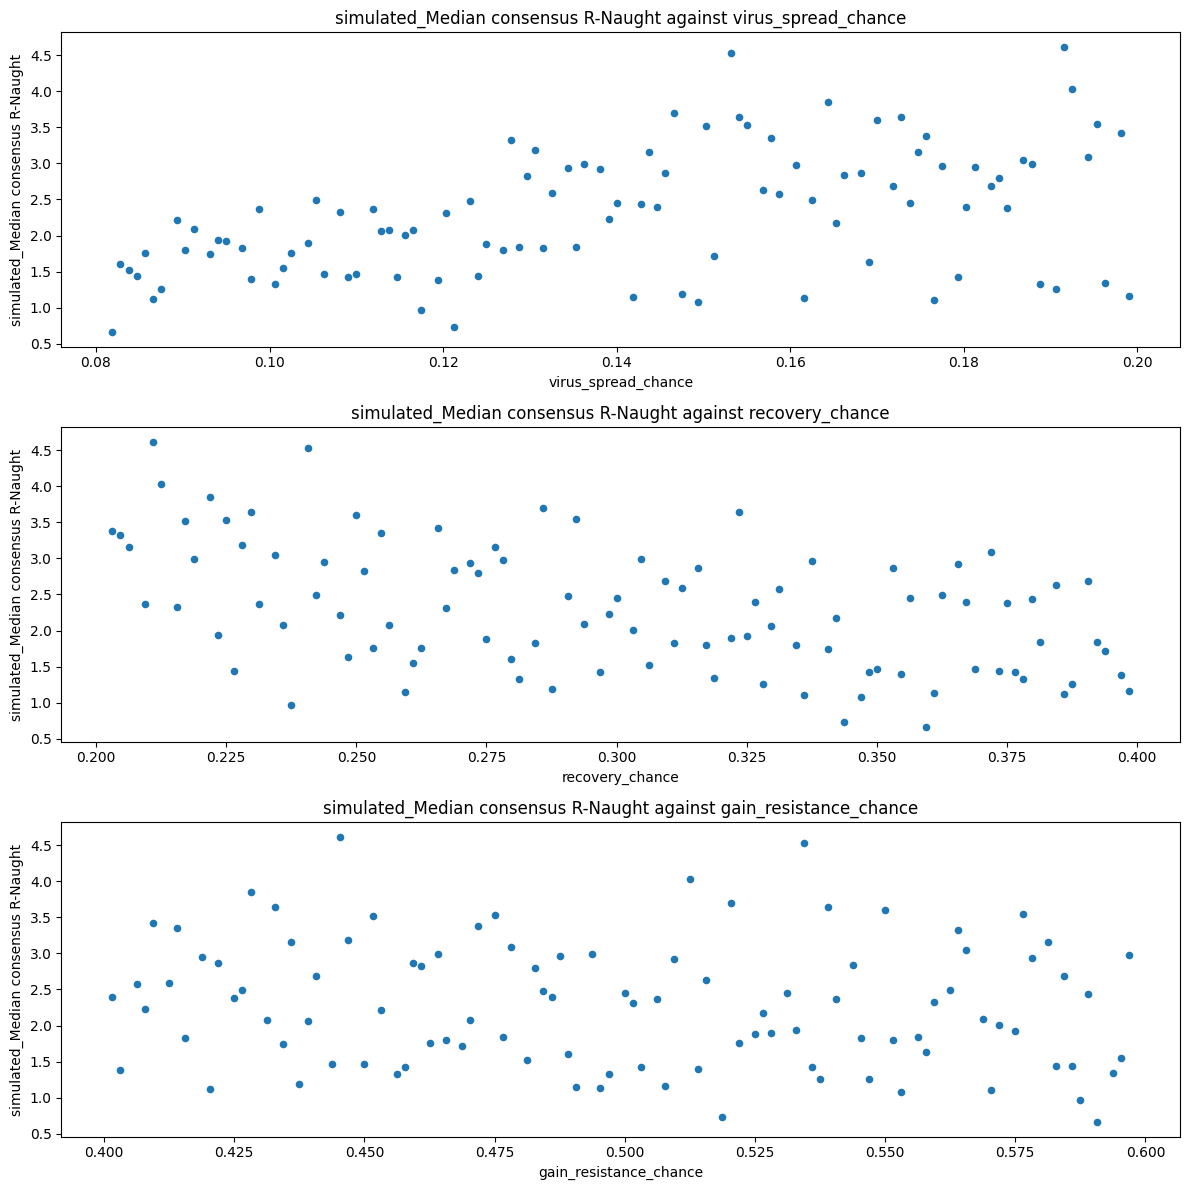

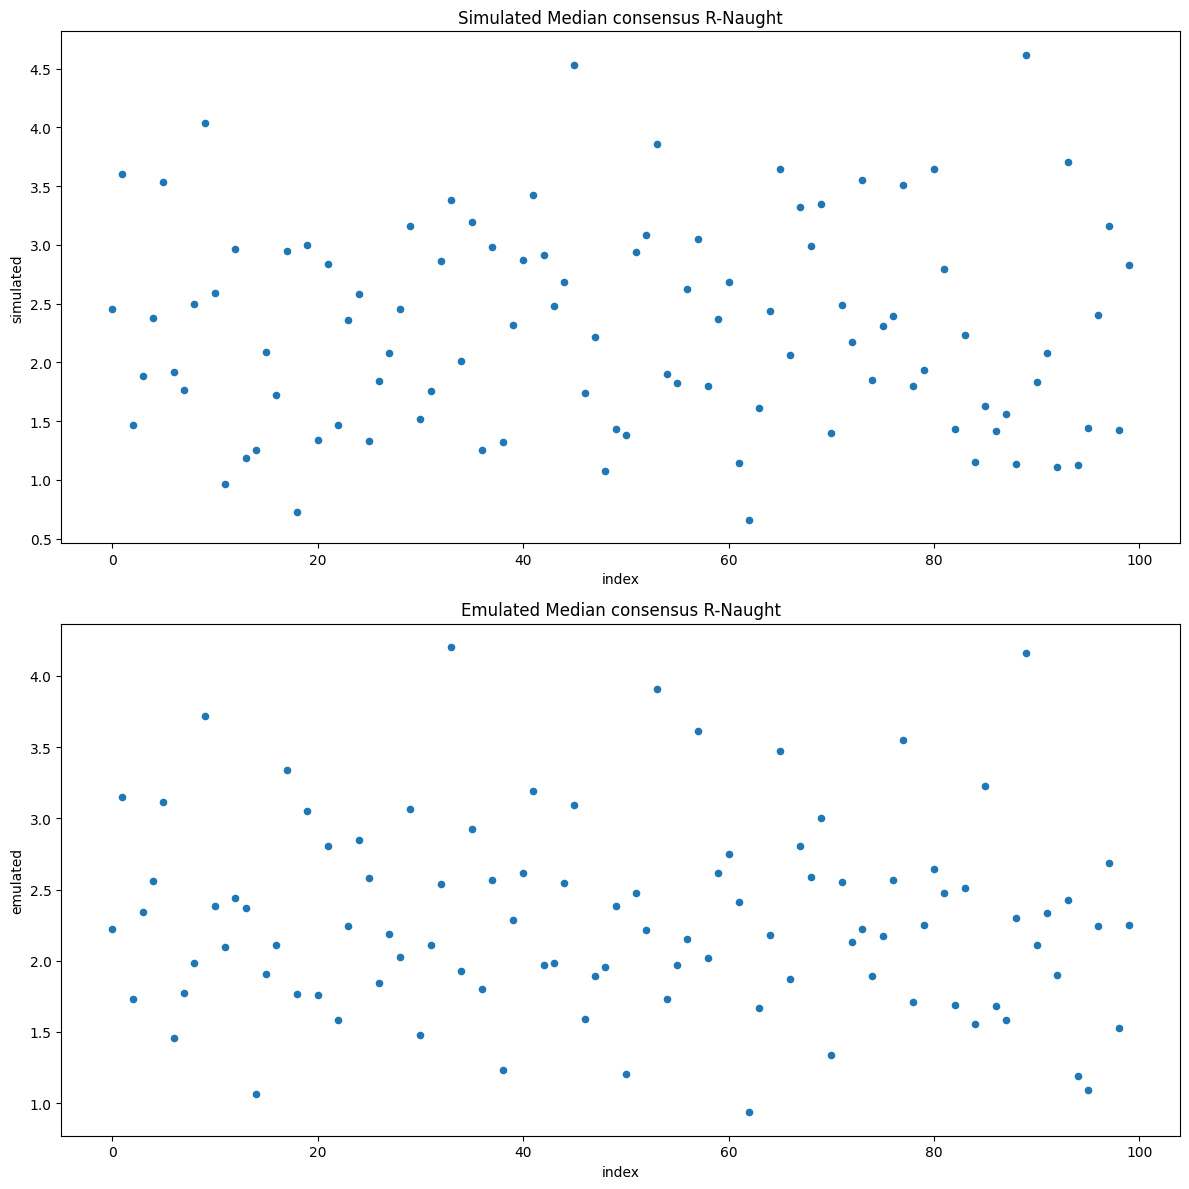

In [17]:
specification = SurrogateModelMethodModel(
	experiment_name="sklearn_surrogate_modelling",
	parameter_spec=parameter_spec,
	method="gp",
	n_samples=100,
    use_shap=True,
    output_labels=["Median consensus R-Naught"],
	batched=False,
)

calibrator = SurrogateModelMethod(
	calibration_func=surrogate_modelling_func,
	specification=specification,
	engine="sklearn",
)

calibrator.specify().execute().analyze()
surrogate = calibrator.get_emulator()

(-0.5, 799.5, 269.5, -0.5)

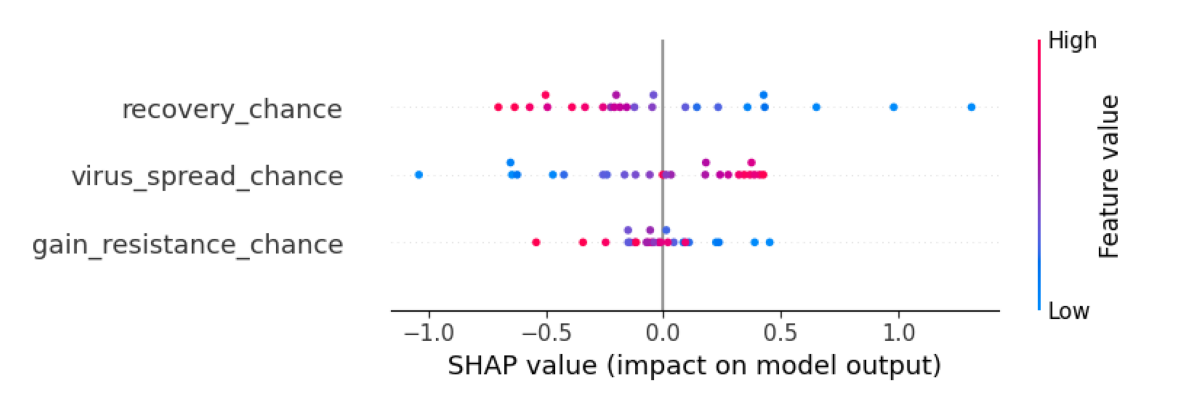

In [18]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread('images/2025-10-28-14-03-00-surrogate_modelling-sklearn_surrogate_modelling-param-importances.png') 

plt.figure(figsize=(15, 15)) 
plt.imshow(img)
plt.axis('off') 

There is a relatively clear positive relationship between **virus_spread_chance** and $R_0$. 

For the local sensitivity analysis, the features on the y-axis are sorted by importance. So **recovery_chance** has greater feature importance than **virus_spread_chance** and **gain_resistance_chance**.

Larger values of **virus_spread_chance**  push the predicted value of $R_0$ above the base value (what the model predicts on average if you know nothing about the specific observation). Smaller values of **virus_spread_chance** push the predicted value of $R_0$ below the base. 

Smaller values of **recovery_chance**  push the predicted value of $R_0$ above the base value (what the model predicts on average if you know nothing about the specific observation). Larger values of **recovery_chance** push the predicted value of $R_0$ below the base. 

# Calibration procedure

## Uncertainty analysis

We will next train an output emulation surrogate model for an uncertainty analysis. We will focus on the analysis of plausible trajectories of infections over time. 

For this exercise, there are three parameters of interest within Virus on a Network: 

- **virus_spread_chance**: The probability of infection.
- **recovery_chance**: The probability of recovery.
- **gain_resistance_chance**:  The probability of gaining disease resistance.

We will first specify our parameter distributions:

In [19]:
def uncertainty_func(
    parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    model = VirusOnNetwork(
        num_nodes = NUM_NODES,
        avg_node_degree = AVG_NODE_DEGREE,
        initial_outbreak_size = INITIAL_OUTBREAK_SIZE,
        virus_spread_chance = parameters["virus_spread_chance"],
        virus_check_frequency = VIRUS_CHECK_FREQUENCY,
        recovery_chance = parameters["recovery_chance"],
        gain_resistance_chance = parameters["gain_resistance_chance"],
    )
    
    for _ in range(N_DAYS):
        model.step()
    
    state_df = model.datacollector.get_model_vars_dataframe()
    infected = state_df.Infected.values
    
    return infected

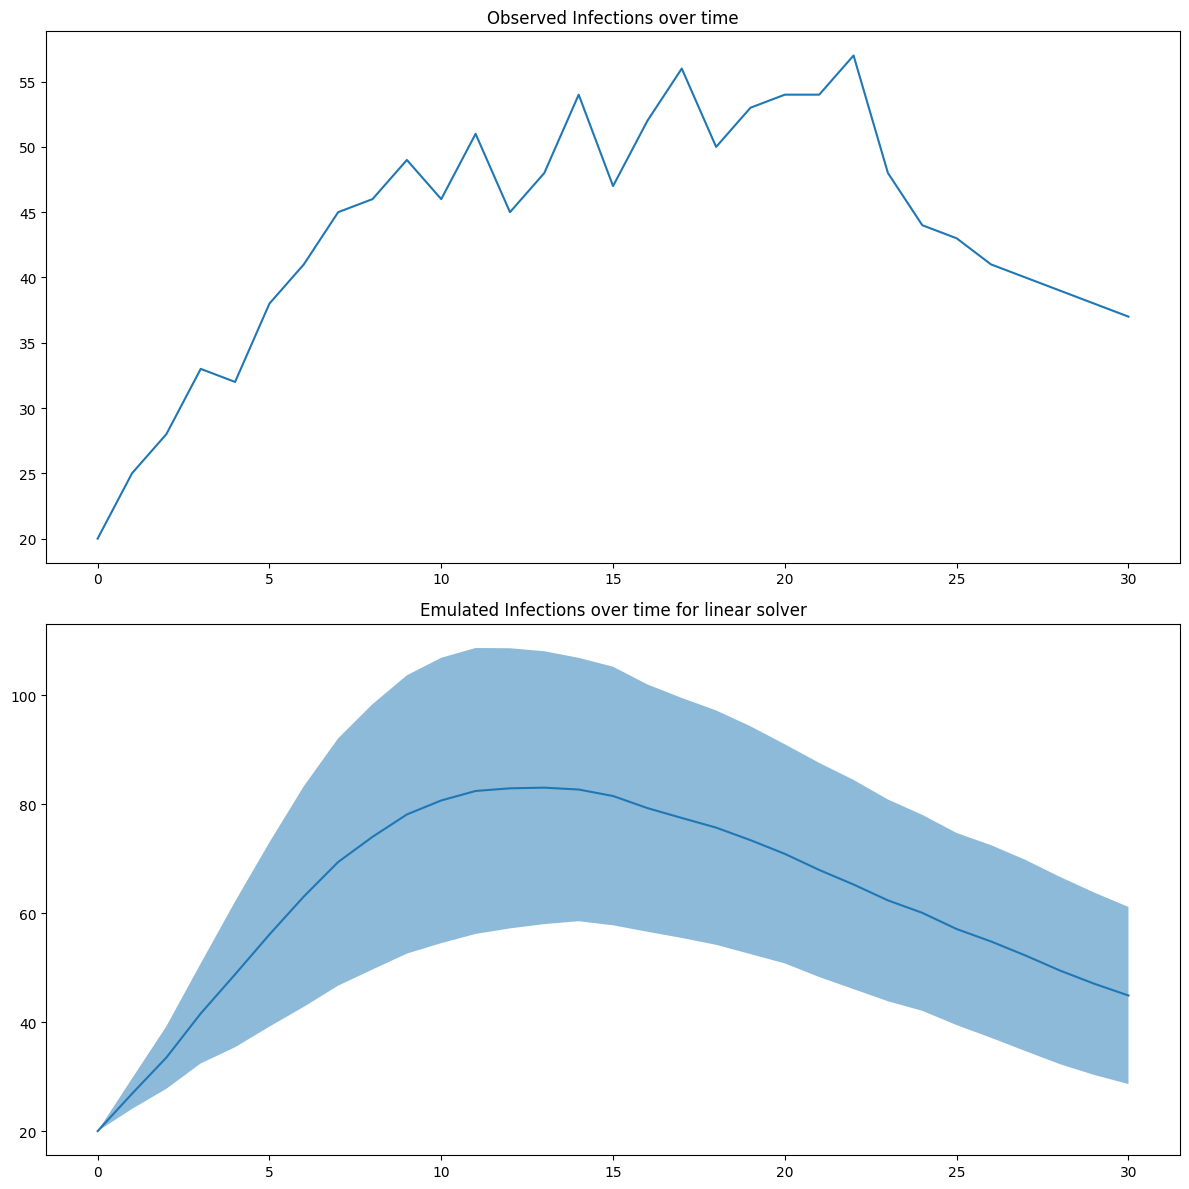

In [22]:
specification = UncertaintyAnalysisMethodModel(
	experiment_name="chaospy_uncertainty_analysis",
	parameter_spec=parameter_spec,
    observed_data = reference_state_df.Infected.values,
	solver="linear",
	algorithm="least_squares",
	method="sobol",
	order=2,
	n_samples=200,
    output_labels=["Infections over time"],
	flatten_Y=True,
	batch=False,
	method_kwargs=dict(rule="cholesky", normed=False, cross_truncation=1.0),
)

calibrator = UncertaintyAnalysisMethod(
	calibration_func=uncertainty_func, specification=specification, engine="chaospy"
)

calibrator.specify().execute().analyze()

We can see the results of the uncertainty analysis above. By using a PCE surrogate, we are able to construct a distribution of plausible trajectories for our simulated infections over time. We have the mean trajectory of infections, alongside the standard deviation.

The mean trajectory is smooth relative to the reference simulation. Uncertainty is greatest around day 10. 